# MIAS Classification using VGG16 Transfer Learning


- Goal : Is to detect the mass and segment it on Mammography Images of DDSM Data
- This Notebook looks at a smaller dataset MIAS and attempts at classifying betweeN Normal vs Cancerous
- This is to explore the type of data , Features used  and also required preprocessing
- VGG Bottle Neck features are used. A Dense Layer with Heavy Regularization is used to learn 
- Idea is to train a separate R CNN to segment the Mass and the same network to classify as Malignant vs Benign


In [1]:
import os
import sys
import time
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import color

from scipy import misc
import gc

import keras.callbacks as cb
import keras.utils.np_utils as np_utils
from keras import applications
from keras import regularizers
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, GaussianNoise


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10)
np.set_printoptions(precision=2)

# import MIAShelper as MIAS

In [3]:
import csv
import collections
from scipy import misc
import numpy as np
import os
import gc
import shutil
import imageio
def clean_meta(meta_data, imgPath):
    print ('Number of entries in incoming meta_data: {}'.format(len(meta_data)))
    found = 0
    not_found = 0
    notfoundfn = []
    for i, fn in enumerate(meta_data.keys()):
        filepath = os.path.join(imgPath, fn)
        if os.path.exists(filepath):
            found += 1
        else:
            notfoundfn.append(fn) 
            not_found += 1

    for f in notfoundfn:
        del meta_data[f]
        
    print ('Images found: {}'.format(found))
    print ('Images missing: {}'.format(not_found))
    print ('Number of entries of outgoing meta_data: {}'.format(len(meta_data)))

    return meta_data

def load_meta(metaFile, patho_idx, file_idx):
    bcMetaFile = {}
    bcCounts = collections.defaultdict(int)
    
    with open(metaFile, 'r') as csvfile:
        bcCSV = csv.reader(csvfile)
        headers = next(bcCSV)
        for row in bcCSV:
            patho = row[ patho_idx].lower()
            bcMetaFile[ row[file_idx]] = patho
            bcCounts[patho] += 1
    
        for k in bcCounts:
            print( '{0:10}: {1}'.format(k, bcCounts[k]))
            
    
    return bcMetaFile, bcCounts

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Pre Processing **
- All Images are enhanced using CLAHE (Contrast Limited Adaptive Histogram Equalization)
  -- https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
- An Adaptive Median Thresholding is performed to Remove the lines, Letters and other Boxes irrelevant to the Breast Image
- Refer to MIASPreprocessing.py

*Note: Manual Input is taken inorder to improve accuracy of Pre Processing*

** Load the PreProcessed Data **

In [5]:
SEED = 7
np.random.seed(SEED)

CURR_DIR  = os.getcwd()
ImagesDir  = '/content/drive/My Drive/Project/Breast-Cancer-Detection/Code/MISA/mias/'
# AugmentedImagesDir   = 'C:\\Users\\310127474\\DDSMData\\MIAS\\MIAS\\AUG'
meta_file = '/content/drive/My Drive/Project/Breast-Cancer-Detection/Code/meta_data_mias.csv'
PATHO_INX = 6    # Column number of pathology label in meta_file
FILE_INX  = 1    # Column number of File name in meta_file

meta_data, _ = load_meta(meta_file, patho_idx=5, file_idx=1)
meta_data = clean_meta(meta_data,ImagesDir)
items = ['normal','abnormal']
labels = {}
from skimage.transform import resize
def load_data(metaData, imgPath, categories, imgSize = (255,255), imgResize = None,
              verbose = True,  verboseFreq = 20):
    total = len(metaData)
    
    x, y = imgSize
    if imgResize is not None:
        x, y = imgResize
    
    # Allocate containers for the data
    X_data = np.zeros( [total, x, y])
    Y_data = np.zeros( [total, 1], dtype=np.int8)
    
    # Load images based on meta_data:
    for i, fn in enumerate( metaData.keys()):
        filepath = os.path.join(imgPath, fn)
        if os.path.exists(filepath):
            img = imageio.imread(filepath)
        else:
            img = None
            print ("Not Found: " + filepath)
            
        if imgResize is not None:
            img = resize(img, imgResize)
            gc.collect()
        
        X_data[i] = img
        Y_data[i] = categories[ metaData[fn].lower()]
        
    X_data = X_data.astype('float32')
    X_data /= float(255)

    return X_data, Y_data

for i, item in enumerate(items):
    labels[item] = i

X_data, Y_data = load_data(meta_data, ImagesDir, labels,imgResize=(224,224))

abnormal  : 124
normal    : 206
Number of entries in incoming meta_data: 330
Images found: 322
Images missing: 8
Number of entries of outgoing meta_data: 322


In [51]:
print( X_train.shape)
print( Y_train.shape)

(280, 224, 224)
(280, 1)


# Display PreProcessed Images

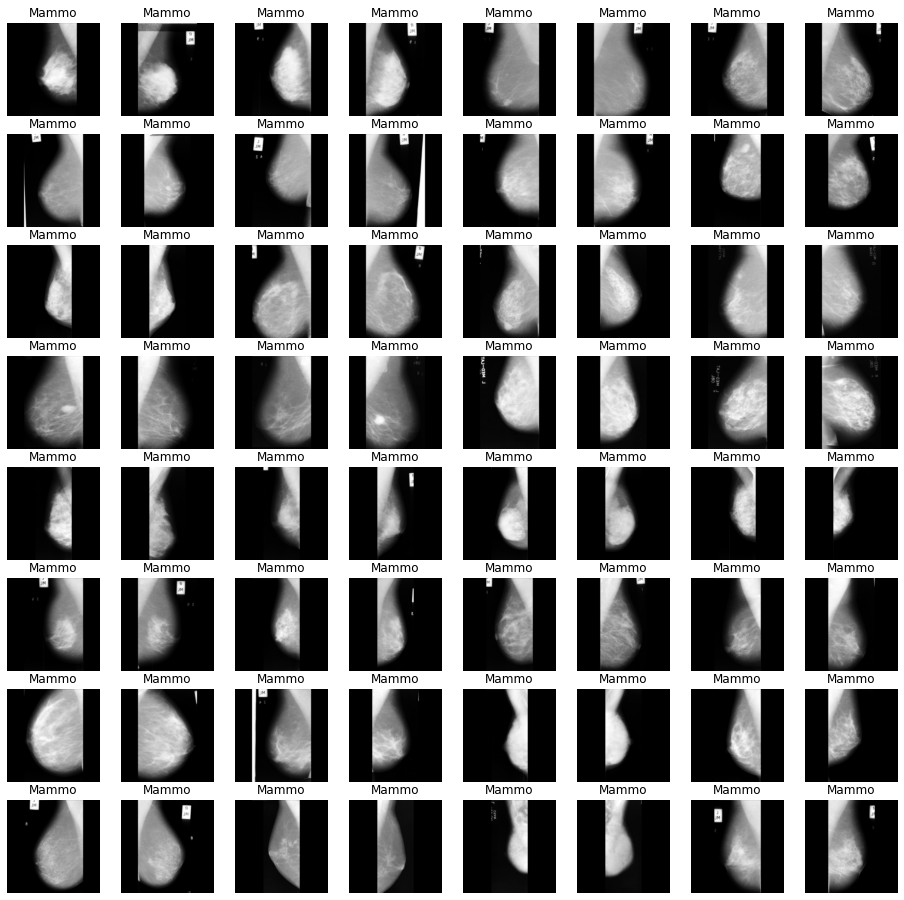

In [6]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Pick 32 Images for Display
for i in np.arange(64):
    axs[i].axis('off')
    axs[i].set_title('Mammo', fontsize=12)
    axs[i].imshow(X_data[i,:,:],cmap='gray')


In [7]:
AugmentedImagesDir = "/content/drive/My Drive/Project/Breast-Cancer-Detection/Code/MISA/Augment"

In [8]:
datagen = ImageDataGenerator(rotation_range=5, width_shift_range=.01, height_shift_range=0.01,
                             data_format='channels_first')

def reverseDict(d):
    ndxBC = {}
    for k in d:
        ndxBC[d[k]] = k

    return ndxBC
    
def get_clsCnts(y_data, cats):
    ys = np.ravel(y_data)
    labels = reverseDict(cats)
    bcCounts = collections.defaultdict(int)

    for lab in ys:
        bcCounts[lab] += 1
    try:
        for key, value in labels.items():
            bcCounts[value] = bcCounts.pop(key)
    except KeyError:
        pass
    return bcCounts

cls_cnts = get_clsCnts(Y_data, labels)

In [9]:
def balanceViaSmote(cls_cnts, meta_info, data_dir, aug_dir, catagories,
                    datagen, X_data, Y_data, imgResize = None, seed=None, verbose=False):
    aug_imgs = []

    if seed:
        np.random.seed(seed)

    max_class_key = max(cls_cnts, key=cls_cnts.get)
    max_class_val = cls_cnts[ max_class_key ]

    for key, value in cls_cnts.items():
        if key == max_class_key:
            pass
        else:
            grow_by = max_class_val - value
            imgs = {k:v for k, v in meta_info.items() if v == key}
            # take a random selection of grow_by size, with replacement
            key_indxs = np.random.choice(list(imgs.keys()), size=grow_by, replace=True)
            for k1 in key_indxs:
                aug_imgs.append({k:v for k,v in imgs.items() if k == k1})

            save_dir = aug_dir +  '_' + key + '/'

            # Overwrite folder and contents if folder exists:
            if os.path.exists(save_dir):
                shutil.rmtree(save_dir)
            os.makedirs(save_dir)

            # Load randomly selected images of given catagory into memory
            aug_X = list()
            aug_Y = list()
            for i in aug_imgs:
                img_x, img_y = load_data(i, data_dir, catagories, imgResize=imgResize)
                aug_X.append(img_x)
                aug_Y.append(img_y)

            # Generate augmented images
            aug_X = np.reshape(aug_X, (len(aug_X), aug_X[0].shape[0], aug_X[0].shape[1], aug_X[0].shape[2]))

            for x_batch, y_batch in datagen.flow(aug_X, aug_Y, batch_size=len(aug_X), seed=seed,
                                                 save_to_dir= save_dir,
                                                 save_prefix= key + '_aug',
                                                 save_format= 'png'):
                X_data = np.concatenate(
                    (X_data, np.reshape(x_batch, (len(x_batch), x_batch.shape[2], x_batch.shape[3]))))
                Y_data = np.concatenate((Y_data, np.reshape(y_batch, (len(y_batch), y_batch.shape[2]))))
                break

    if verbose:
        bcCounts = get_clsCnts(Y_data, catagories)
        
        for k in bcCounts:
            print ('{0:10}: {1}'.format(k, bcCounts[k]))

    return X_data, Y_data

# Balance the dataset via SMOTE

In [52]:
X_data, Y_data = balanceViaSmote(cls_cnts, meta_data, ImagesDir, AugmentedImagesDir, labels, 
                                    datagen, X_data, Y_data, imgResize=(224,224),seed=SEED, verbose=True)

normal    : 200
abnormal  : 278


# Train Test Split

In [53]:
np.random.seed(111)
print( X_train.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data,
                                                    test_size=0.3,
                                                    random_state=7,
                                                    )
print( X_train.shape)
print( X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

data = [X_train, X_test, Y_train, Y_test]

(280, 224, 224)
(334, 224, 224)
(144, 224, 224)
(334, 1)
(144, 1)


# Method
In the following we will compare three models: A simple model, resnet50   MobileNet and VGG16 as the literature suggests these perform best. We will do so by keeping the parameters constant to select the best performing architecture and then choose the winning model in terms of accuracy to perform fine tuning.





# Prepare VGG16 Bottle neck features

In [54]:
def VGGPrep(img_data):
    
    images = np.zeros([len(img_data), img_data.shape[1], img_data.shape[2], 3])
    for i in range(0, len(img_data)):
        im = (img_data[i] * 255)        # Original imagenet images were not rescaled
        im = color.gray2rgb(im)
        images[i] = im
    return(images)

In [55]:
def vgg16_bottleneck(data, modelPath, fn_train_feats, fn_train_lbls, fn_test_feats, fn_test_lbls):
    # Loading data
    X_train, X_test, Y_train, Y_test = data
    
    X_train = VGGPrep(X_train)
    X_test = VGGPrep(X_test)
        
    model = applications.VGG16(include_top=False, weights='imagenet') 
    
    # Predict passes data through the model 
    bottleneck_features_train = model.predict(X_train)
    
    # Saving the bottleneck features for the training data
    featuresTrain = os.path.join(modelPath, fn_train_feats)
    labelsTrain = os.path.join(modelPath, fn_train_lbls)
    
    np.save(open(featuresTrain, 'wb'), bottleneck_features_train)
    np.save(open(labelsTrain, 'wb'), Y_train)

    
    bottleneck_features_test = model.predict(X_test)
    
    # Saving the bottleneck features for the test data
    featuresTest = os.path.join(modelPath, fn_test_feats)
    labelsTest = os.path.join(modelPath, fn_test_lbls)
    np.save(open(featuresTest, 'wb'), bottleneck_features_test)
    np.save(open(labelsTest, 'wb'), Y_test)

# Save VGG16 Bottleneck features

In [56]:
# Locations for the bottleneck and labels files that we need
train_bottleneck = 'features_train.npy'
train_labels     = 'labels_train.npy'
test_bottleneck  = 'features_test.npy'
test_labels      = 'labels_test.npy'
modelPath = os.getcwd()

top_model_weights_path = './weights/'

np.random.seed(SEED)
vgg16_bottleneck(data, modelPath, train_bottleneck, train_labels, test_bottleneck, test_labels)

58892288/58889256 [==============================] - 0s 0us/step


In [64]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        
    def on_epoch_end(self, epoch, logs={}):
        epoch_tr_loss  = logs.get('loss')
        epoch_val_loss = logs.get('val_loss')
        self.losses.append([epoch_tr_loss, epoch_val_loss])
        
        epoch_tr_acc  = logs.get('accuracy')
        epoch_val_acc = logs.get('val_accuracy')
        self.acc.append([epoch_tr_acc, epoch_val_acc])

In [65]:
def plot_losses(losses, acc):
    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.plot(losses)
    ax.set_title('Model Loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    
    ax = fig.add_subplot(222)
    ax.plot(acc)
    ax.set_title('Model Accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')

# Model with Heavy Regularization

In [109]:
import keras
def train_model(train_feats, train_lab, test_feats, test_lab, model_path, model_save, epoch = 50, batch = 64):
    start_time = time.time()
    
    train_bottleneck = os.path.join(model_path, train_feats)
    train_labels = os.path.join(model_path, train_lab)
    test_bottleneck = os.path.join(model_path, test_feats)
    test_labels = os.path.join(model_path, test_lab)
    
    history = LossHistory()
    
    X_train = np.load(train_bottleneck)
    Y_train = np.load(train_labels)
    Y_train = np_utils.to_categorical(Y_train, num_classes=2)
    
    X_test = np.load(test_bottleneck)
    Y_test = np.load(test_labels)
    Y_test = np_utils.to_categorical(Y_test, num_classes=2)

    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add( Dropout(0.7))
    model.add( Dense(256, activation='relu' ))
    model.add( Dropout(0.5))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(2, activation='softmax'))
    
    adam_customlr =  keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")
    model.compile(optimizer= 'rmsprop',  # adadelta
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              epochs=epoch,
              batch_size=batch,
              callbacks=[history],
              validation_data=(X_test, Y_test),
              verbose=2)
    
    print ("Training duration : {0}".format(time.time() - start_time))
    score = model.evaluate(X_test, Y_test, batch_size=16, verbose=2)

    print ("Network's test score [loss, accuracy]: {0}".format(score))
    print ('CNN Error: {:.2f}%'.format(100 - score[1] * 100))
    
    #bc.save_model(model_save, model, "jn_VGG16_Detection_top_weights_threshold.h5")
    
    return model, history.losses, history.acc, score

In [110]:
np.random.seed(SEED)
(trans_model, loss_cnn, acc_cnn, test_score_cnn) = train_model(train_feats=train_bottleneck,
                                                                   train_lab=train_labels, 
                                                                   test_feats=test_bottleneck, 
                                                                   test_lab=test_labels,
                                                                   model_path=modelPath, 
                                                                   model_save=top_model_weights_path,
                                                                   epoch=200)

Epoch 1/200
6/6 - 0s - loss: 5.7904 - accuracy: 0.5180 - val_loss: 5.7514 - val_accuracy: 0.6250
Epoch 2/200
6/6 - 0s - loss: 5.1865 - accuracy: 0.5659 - val_loss: 2.5379 - val_accuracy: 0.5417
Epoch 3/200
6/6 - 0s - loss: 2.7483 - accuracy: 0.5299 - val_loss: 0.9195 - val_accuracy: 0.5625
Epoch 4/200
6/6 - 0s - loss: 1.2272 - accuracy: 0.5509 - val_loss: 0.7625 - val_accuracy: 0.5486
Epoch 5/200
6/6 - 0s - loss: 0.8275 - accuracy: 0.5599 - val_loss: 0.7359 - val_accuracy: 0.5417
Epoch 6/200
6/6 - 0s - loss: 0.7095 - accuracy: 0.5689 - val_loss: 0.6348 - val_accuracy: 0.6736
Epoch 7/200
6/6 - 0s - loss: 0.6711 - accuracy: 0.6138 - val_loss: 0.7052 - val_accuracy: 0.6250
Epoch 8/200
6/6 - 0s - loss: 0.6967 - accuracy: 0.5778 - val_loss: 0.6396 - val_accuracy: 0.6181
Epoch 9/200
6/6 - 0s - loss: 0.7410 - accuracy: 0.5449 - val_loss: 0.6550 - val_accuracy: 0.5764
Epoch 10/200
6/6 - 0s - loss: 0.6747 - accuracy: 0.5898 - val_loss: 0.6855 - val_accuracy: 0.5625
Epoch 11/200
6/6 - 0s - loss:

**- Network's test score [loss, accuracy]: [4.0544894790649417, 0.72999999999999998]**


<Figure size 720x720 with 0 Axes>

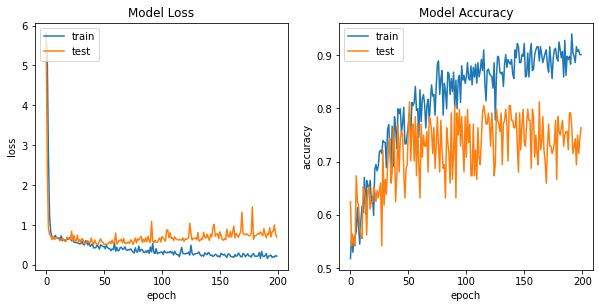

In [111]:
plt.figure(figsize=(10,10))
plot_losses(loss_cnn, acc_cnn)